In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! unzip -q '/content/drive/My Drive/Colab Notebooks/train.zip' -d dataset
! unzip -q '/content/drive/My Drive/Colab Notebooks/test.zip' -d dataset

In [ ]:
# %tensorflow_version 1.x
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image_dataset
from keras.models import load_model
from sklearn.metrics import accuracy_score

In [ ]:
def load_data3(path, batch_size, split=False):
    if split:
      datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
      return datagen.flow_from_directory(
              path,
              target_size=(197, 197),
              shuffle = True,
              class_mode='categorical',
              batch_size=batch_size,
              subset='training'), datagen.flow_from_directory(
              path,
              target_size=(197, 197),
              class_mode='categorical',
              batch_size=batch_size,
              subset='validation')
    else:
      datagen = ImageDataGenerator(rescale=1./255)
      return datagen.flow_from_directory(
              path,
              target_size=(197, 197),
              shuffle=False,
              class_mode='categorical',
              batch_size=batch_size,
              color_mode='rgb'), None
def load_ds(train_path, test_path, batch_size, image_size):
    train_data = image_dataset.image_dataset_from_directory(
            train_path, 
            label_mode='categorical',
            batch_size=batch_size,
            image_size=(image_size, image_size), 
            shuffle=True, 
            seed=1337,
            validation_split=0.2,
            subset="training")
    val_data = image_dataset.image_dataset_from_directory(
            train_path, 
            label_mode='categorical',
            batch_size=batch_size,
            image_size=(image_size, image_size), 
            shuffle=True, 
            seed=1337,
            validation_split=0.2,
            subset="validation")
    test_data = image_dataset.image_dataset_from_directory(
            test_path, 
            label_mode='categorical',
            batch_size=batch_size,
            image_size=(image_size, image_size), 
            shuffle=False)
    return train_data, val_data, test_data

In [ ]:
test3_generator128, _ = load_data3('/content/test', 128)
test3_generator64, _ = load_data3('/content/test', 64)
_, _, test_ds197 = load_ds("/content/train", "/content/test", 128, 197)
_, _, test_ds48 = load_ds("/content/train", "/content/test", 128, 48)

Found 5512 images belonging to 7 classes.
Found 5512 images belonging to 7 classes.
Found 22035 files belonging to 7 classes.
Using 17628 files for training.
Found 22035 files belonging to 7 classes.
Using 4407 files for validation.
Found 5512 files belonging to 7 classes.
Found 22035 files belonging to 7 classes.
Using 17628 files for training.
Found 22035 files belonging to 7 classes.
Using 4407 files for validation.
Found 5512 files belonging to 7 classes.


In [ ]:
import numpy as np
# make an ensemble prediction for multi-class classification
def ensemble_predictions(models_TL):
  # make predictions
  yhats = np.zeros((len(models_TL),5512,7))

  for model_ind in range(len(models_TL)):
    (model, data) = models_TL[model_ind]
    yhat = model.predict(data)
    yhats[model_ind,:,:] = yhat

  summed = np.sum(yhats, axis=0)
  result = np.argmax(summed, axis=1)
  return result

In [ ]:
def svm_loss(layer):
    weights = layer.weights[0]
    weights_tf = tf.convert_to_tensor(weights)
    
    def categorical_hinge_loss(y_true, y_pred):
        pos = K.sum(y_true * y_pred, axis=-1)
        neg = K.max((1.0 - y_true) * y_pred, axis=-1)
        hinge_loss = K.mean(K.maximum(0.0, neg - pos + 1), axis=-1)
        regularization_loss = 0.5*(tf.reduce_sum(tf.square(weights_tf)))
        return regularization_loss + 0.4*hinge_loss
    
    return categorical_hinge_loss

In [ ]:
vgg_model = load_model('/content/drive/MyDrive/model/VGG16/VGG16_sgd_-EPOCHS_120-DROPOUT_0.5-test_acc_0.683.h5')
print('\n# Evaluate on test data')
results_test = vgg_model.evaluate(test_ds197)
print('test loss, test acc:', results_test)


# Evaluate on test data
44/44 [==============================] - 11s 252ms/step - loss: 0.9335 - accuracy: 0.6831
test loss, test acc: [0.9334800243377686, 0.6830551624298096]


In [ ]:
vgg_svm_model = load_model('/content/drive/MyDrive/model/VGG16/SVM_VGG16_sgd_-EPOCHS_120-DROPOUT_0.5-test_acc_0.669.h5', compile=False)
vgg_svm_model.compile(loss=svm_loss(vgg_svm_model.get_layer('svm')), metrics='accuracy')
print('\n# Evaluate on test data')
results_test = vgg_svm_model.evaluate(test_ds197)
print('test loss, test acc:', results_test)


# Evaluate on test data
44/44 [==============================] - 11s 244ms/step - loss: 7.0577 - accuracy: 0.6685
test loss, test acc: [7.057663440704346, 0.6685413718223572]


In [ ]:
resnet50_model = load_model('/content/drive/MyDrive/model/Resnet50/resnet50-weights-best.h5')
print('\n# Evaluate on test data')
results_test = resnet50_model.evaluate(test3_generator128)
print('test loss, test acc:', results_test)


# Evaluate on test data
44/44 [==============================] - 6s 126ms/step - loss: 1.0349 - accuracy: 0.6856
test loss, test acc: [1.0348896980285645, 0.6855950355529785]


In [ ]:
resnet50_svm_model = load_model('/content/drive/MyDrive/model/Resnet50/resnet50-weights-best-svm.h5', compile=False)
resnet50_svm_model.compile(loss=svm_loss(resnet50_svm_model.get_layer('svm')), metrics='accuracy')
print('\n# Evaluate on test data')
results_test = resnet50_svm_model.evaluate(test3_generator128)
print('test loss, test acc:', results_test)


# Evaluate on test data
44/44 [==============================] - 6s 128ms/step - loss: 0.3025 - accuracy: 0.6927
test loss, test acc: [0.3024950921535492, 0.6926705241203308]


In [ ]:
resnet18_model = load_model('/content/drive/MyDrive/model/Resnet18/RESNET18.h5')
print('\n# Evaluate on test data')
results_test = resnet18_model.evaluate(test3_generator128)
print('test loss, test acc:', results_test)


# Evaluate on test data
44/44 [==============================] - 5s 119ms/step - loss: 5.2457 - accuracy: 0.4345
test loss, test acc: [5.245748996734619, 0.43450653553009033]


In [ ]:
resnet18_svm_model = load_model('/content/drive/MyDrive/model/Resnet18/RESNET18_svm.h5', compile=False)
resnet18_svm_model.compile(loss=svm_loss(resnet18_svm_model.get_layer('svm')), metrics='accuracy')
print('\n# Evaluate on test data')
results_test = resnet18_svm_model.evaluate(test3_generator128)
print('test loss, test acc:', results_test)


# Evaluate on test data
44/44 [==============================] - 5s 111ms/step - loss: 8.5918 - accuracy: 0.3572
test loss, test acc: [8.59176254272461, 0.3572206199169159]


In [ ]:
base_model = load_model('/content/drive/MyDrive/model/Baseline/baseline-EPOCHS_150-DROPOUT_0.3-test_acc_0.675.h5')
print('\n# Evaluate on test data')
results_test = base_model.evaluate(test_ds48)
print('test loss, test acc:', results_test)


# Evaluate on test data
44/44 [==============================] - 2s 54ms/step - loss: 1.5137 - accuracy: 0.6751
test loss, test acc: [1.5137064456939697, 0.6750725507736206]


In [ ]:
base_svm_model = load_model('/content/drive/MyDrive/model/Baseline/baseline-EPOCHS_50-DROPOUT_0.3-test_acc_0.675_svm.h5', compile=False)
base_svm_model.compile(loss=svm_loss(base_svm_model.get_layer('svm')), metrics='accuracy')
print('\n# Evaluate on test data')
results_test = base_svm_model.evaluate(test_ds48)
print('test loss, test acc:', results_test)


# Evaluate on test data
44/44 [==============================] - 2s 49ms/step - loss: 9.0947 - accuracy: 0.6745
test loss, test acc: [9.09469985961914, 0.6745283007621765]


In [ ]:
senet50_model = load_model('/content/drive/MyDrive/model/Senet50/senet50-weights-best.h5')
print('\n# Evaluate on test data')
results_test = senet50_model.evaluate(test3_generator64)
print('test loss, test acc:', results_test)


# Evaluate on test data
87/87 [==============================] - 6s 68ms/step - loss: 1.1435 - accuracy: 0.6239
test loss, test acc: [1.143450140953064, 0.623911440372467]


In [ ]:
senet50_svm_model = load_model('/content/drive/MyDrive/model/Senet50/senet50-weights-best-svm.h5', compile=False)
senet50_svm_model.compile(loss=svm_loss(senet50_svm_model.get_layer('svm')), metrics='accuracy')
print('\n# Evaluate on test data')
results_test = senet50_svm_model.evaluate(test3_generator64)
print('test loss, test acc:', results_test)


# Evaluate on test data
87/87 [==============================] - 6s 69ms/step - loss: 0.3276 - accuracy: 0.6297
test loss, test acc: [0.3275565207004547, 0.6297169923782349]


In [ ]:
models_TL = [(vgg_model, test_ds197), (vgg_svm_model, test_ds197), (resnet50_model, test3_generator128), (resnet50_svm_model, test3_generator128), (senet50_model, test3_generator64), (base_model, test_ds48)]

In [ ]:
result = ensemble_predictions(models_TL)
labels = test3_generator128.classes
accuracy_score(result, labels)

0.7293178519593614

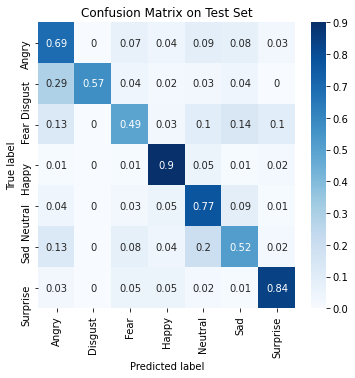

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}

cmat_df_test=pd.DataFrame(
    confusion_matrix(labels, result, normalize='true').round(2),
    index=emotions.values(), 
    columns=emotions.values()
    )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
models_TL2 = [(vgg_svm_model, test_ds197), (resnet50_svm_model, test3_generator128), (senet50_svm_model, test3_generator64), (base_svm_model, test_ds48)]

In [ ]:
result2 = ensemble_predictions(models_TL2)
labels = test3_generator128.classes
accuracy_score(result2, labels)

0.7171625544267054

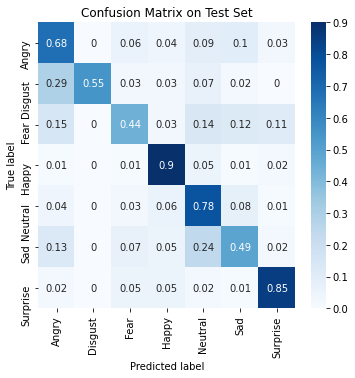

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}

cmat_df_test=pd.DataFrame(
    confusion_matrix(labels, result2, normalize='true').round(2),
    index=emotions.values(), 
    columns=emotions.values()
    )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()